In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from scipy.stats import lognorm
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline



forest = pd.read_csv('./csv/forest.csv', sep = ',')
forest_area = pd.read_csv('./csv/forest_area.csv', sep = ',')
brazil_loss = pd.read_csv('./csv/brazil_loss.csv', sep = ',')
soybean_use = pd.read_csv('./csv/soybean_use.csv', sep = ',')
vegetable_oil = pd.read_csv('./csv/vegetable_oil.csv', sep = ',')
population = pd.read_csv('./csv/population.csv', index_col=[0], sep = ',')
pd.set_option("max_rows", 200)
sns.set_style('darkgrid')
def tamanhoPlot(x, y):
    fig_dims = (x, y)
    fig, ax = plt.subplots(figsize=fig_dims)
    return ax

In [105]:
def filtro(df):
    df1 = df[(df.Código.notna()) & (df['Entidade'] != 'World')]
    df1.dropna(inplace=True)
    return df1

In [106]:
data = filtro(forest)
data.sort_values(['Conversão_líquida_de_floresta'], inplace=True)
data

/home/luan/miniconda3/envs/myenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Entidade,Código,Ano,Conversão_líquida_de_floresta
47,Brazil,BRA,2000,-3950790.0
46,Brazil,BRA,1990,-3780940.0
195,Indonesia,IDN,1990,-1726500.0
48,Brazil,BRA,2010,-1539180.0
49,Brazil,BRA,2015,-1453040.0
...,...,...,...,...
14,Australia,AUS,2010,709680.0
83,China,CHN,2010,1936770.0
84,China,CHN,2015,1936790.0
81,China,CHN,1990,1986000.0


In [107]:
data_area = forest_area[(forest_area.Código.notna()) &(forest_area['Entidade'] != 'World')]
data_f = filtro(forest)
data_area.sort_values('Área_de_Floresta', ascending=False, inplace=True)

data = pd.merge(data_f, data_area)
data.sort_values(['Área_de_Floresta'], ascending=False, inplace=True)
data_vo = filtro(vegetable_oil)
data_test = data_vo.groupby(['Entidade','Código','Ano']).Produção_Óleo.sum().reset_index()
data = pd.merge(data, data_test)


/home/luan/miniconda3/envs/myenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

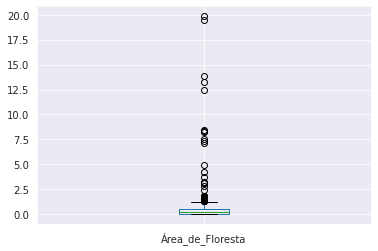

In [108]:
data.boxplot(column=['Área_de_Floresta'])

<AxesSubplot:>

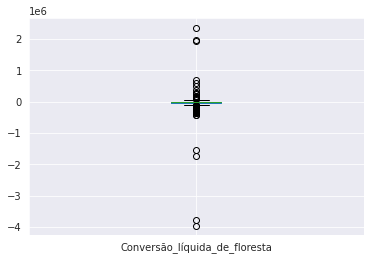

In [109]:
data.boxplot(column=['Conversão_líquida_de_floresta'])

<AxesSubplot:>

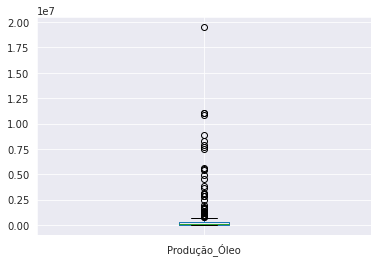

In [110]:
data.boxplot(column=['Produção_Óleo'])

# Esses dados parecidos com outliers vão precisar de um Spatial sign transform

In [111]:
data = pd.merge(data, population)
data['Perde'] = np.select((data.Conversão_líquida_de_floresta<0, data.Conversão_líquida_de_floresta>0), (1,0), 1)
def normalizaPelaPop(data):
    data.Área_de_Floresta = data.Área_de_Floresta / data.População
    data.Conversão_líquida_de_floresta = data.Conversão_líquida_de_floresta / data.População
    data.Produção_Óleo = data.Produção_Óleo / data.População
    return data

#data = normalizaPelaPop(data)
def separaData(data):
    return data.iloc[:,:3], data.iloc[:,4:7], data.iloc[:,3:4], data.iloc[:,7:8]
data_string, data_value,  y, target = separaData(data)
data

,Entidade,Código,Ano,Conversão_líquida_de_floresta,Área_de_Floresta,Produção_Óleo,População,Perde
0,Russia,RUS,2010,-41030.0,19.850775,3007851.0,142849468,1
1,Russia,RUS,2000,586710.0,19.462697,1416153.0,146596869,0
2,Brazil,BRA,1990,-3780940.0,13.900798,3124141.0,149003225,1
3,Brazil,BRA,2000,-3950790.0,13.253538,4509564.0,174790339,1
4,Brazil,BRA,2010,-1539180.0,12.458385,7722526.0,195713637,1
...,...,...,...,...,...,...,...,...
255,Kuwait,KWT,2000,140.0,0.000117,413.0,2045123,0
256,Kuwait,KWT,1990,140.0,0.000081,323.0,2095350,0
257,Maldives,MDV,2010,0.0,0.000020,151.0,365730,1
258,Maldives,MDV,2000,0.0,0.000020,1447.0,279396,1


# Exploratore Analysis

In [112]:
mono = pd.DataFrame({'Estatísticas' : ['Contagem', 'Média', 'Desvio Padrão', 'Mínimo', '1º Quartil', 'Mediana', '3º Quartil', 'Máximo', 'Distorção'],
                     'Área de Floresta %': [data.Área_de_Floresta.count(), data.Área_de_Floresta.mean(), data.Área_de_Floresta.std(),
                                          data.Área_de_Floresta.min(), data.Área_de_Floresta.quantile(.25), data.Área_de_Floresta.quantile(.50),
                                          data.Área_de_Floresta.quantile(.75), data.Área_de_Floresta.max(), data.Área_de_Floresta.skew()],
                     'Produção de Óleo': [data.Produção_Óleo.count(), data.Produção_Óleo.mean(), data.Produção_Óleo.std(),
                                          data.Produção_Óleo.min(), data.Produção_Óleo.quantile(.25), data.Produção_Óleo.quantile(.50),
                                          data.Produção_Óleo.quantile(.75), data.Produção_Óleo.max(), data.Produção_Óleo.skew()],
                     'População': [data.População.count(), data.População.mean(), data.População.std(),
                                          data.População.min(), data.População.quantile(.25), data.População.quantile(.50),
                                          data.População.quantile(.75), data.População.max(), data.População.skew()]})
mono

,Estatísticas,Área de Floresta %,Produção de Óleo,População
0,Contagem,260.000000,2.600000e+02,2.600000e+02
1,Média,0.891752,7.650162e+05,5.352181e+07
2,Desvio Padrão,2.507602,2.134971e+06,1.763970e+08
3,Mínimo,0.000019,1.800000e+01,1.192110e+05
4,1º Quartil,0.045767,1.531350e+04,4.336882e+06
5,Mediana,0.176241,7.677350e+04,1.022095e+07
6,3º Quartil,0.543165,3.640425e+05,3.247578e+07
7,Máximo,19.850775,1.948291e+07,1.337705e+09
8,Distorção,5.178593,4.877443e+00,5.948668e+00


# A distorção dos dados é bem alta, então uma transformação de dados se torna necessária

In [113]:
def tiraDistorcao(df):
    return np.log(df)

data_value = tiraDistorcao(data_value)


In [114]:
def yeo_johnson(y):
    power = PowerTransformer()
    aux1 = pd.DataFrame(y)
    y = power.fit_transform(y)
    data_y = pd.DataFrame(y, index=aux1.index, columns=aux1.columns)
    return y, data_y

y, data_y = yeo_johnson(y)

<AxesSubplot:xlabel='Conversão_líquida_de_floresta', ylabel='Count'>

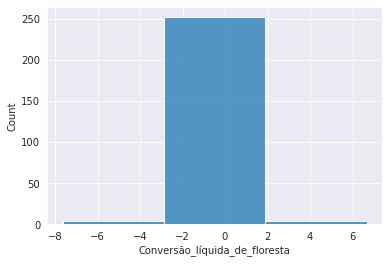

In [115]:
sns.histplot(data_y.Conversão_líquida_de_floresta,bins=3)

<AxesSubplot:xlabel='Área_de_Floresta', ylabel='Count'>

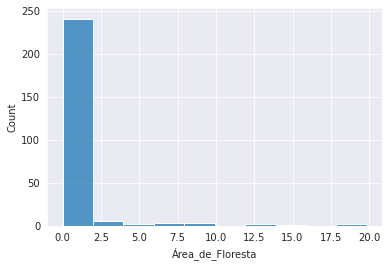

In [116]:
sns.histplot(data.Área_de_Floresta, bins=10)

<AxesSubplot:xlabel='Área_de_Floresta', ylabel='Count'>

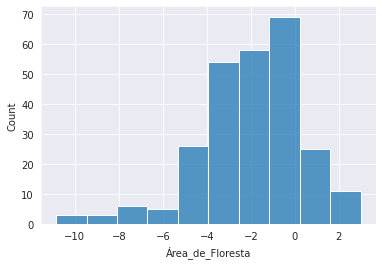

In [117]:
sns.histplot(data_value.Área_de_Floresta, bins=10)

<AxesSubplot:xlabel='Produção_Óleo', ylabel='Count'>

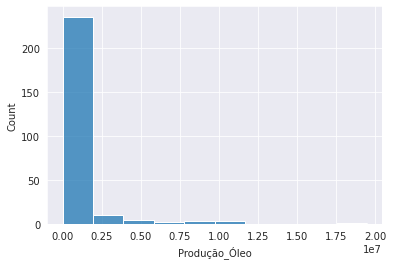

In [118]:
sns.histplot(data.Produção_Óleo, bins=10)

<AxesSubplot:xlabel='Produção_Óleo', ylabel='Count'>

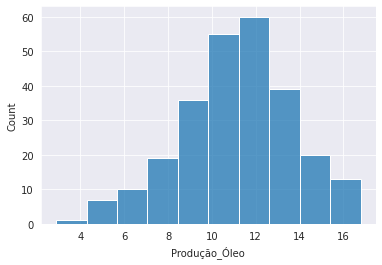

In [119]:
sns.histplot(data_value.Produção_Óleo, bins=10)

<AxesSubplot:xlabel='População', ylabel='Count'>

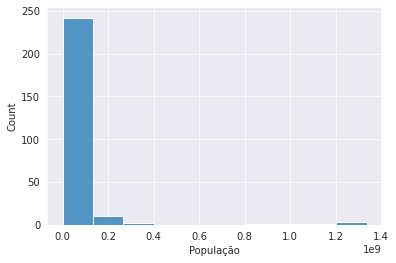

In [120]:
sns.histplot(data.População, bins=10)

<AxesSubplot:xlabel='População', ylabel='Count'>

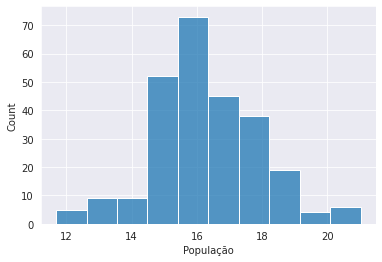

In [121]:
sns.histplot(data_value.População, bins=10)

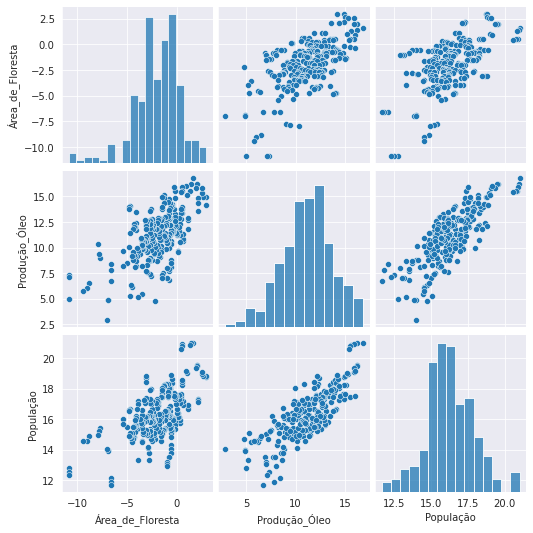

In [122]:
sns.pairplot(data=data_value)

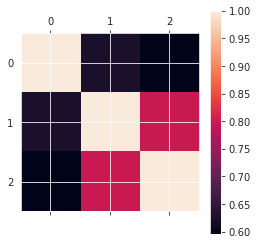

,Área_de_Floresta,Produção_Óleo,População
Área_de_Floresta,1.000000,0.626026,0.596391
Produção_Óleo,0.626026,1.000000,0.796013
População,0.596391,0.796013,1.000000


In [123]:
data.sort_values(['Conversão_líquida_de_floresta'], inplace=True)

plt.matshow(data_value.corr())
cb = plt.colorbar()

plt.show()
data_value.corr()

<AxesSubplot:>

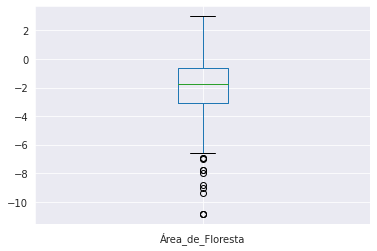

In [124]:
data_value.boxplot(column=['Área_de_Floresta'])

<AxesSubplot:>

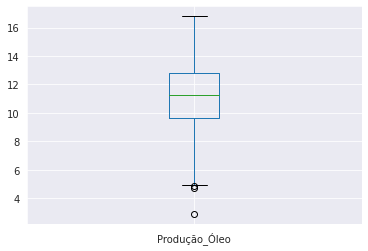

In [125]:
data_value.boxplot(column=['Produção_Óleo'])

<AxesSubplot:>

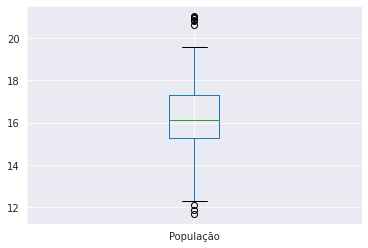

In [126]:
data_value.boxplot(column=['População'])

In [127]:
def spatialSign(df, s, s_aux):
    data_aux = df
    df = preprocessing.normalize(df, norm='l2')
    df = pd.DataFrame(df, index=data_aux.index, columns=data_aux.columns)
    s = preprocessing.normalize(s, norm='l2')
    s = pd.DataFrame(s, index=s_aux.index, columns=s_aux.columns)
    return df, s


# PCA


In [128]:
x = data_value.values
x = StandardScaler().fit_transform(x)


In [129]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, target], axis = 1)


In [130]:

fig = px.scatter(principalComponents, x=0, y=1, color=finalDf['Perde'], color_continuous_scale=["green", "red"])
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')


fig.show()

In [131]:
pca.fit(finalDf)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Componentes", "y": "Variância"}
)

In [132]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features  = ['Área de Floresta', 'Produção de Óleo', 'População']
fig = px.scatter(principalComponents, x=0, y=1, color=finalDf['Perde'], color_continuous_scale=["green", "red"])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

# Regressão Linear

In [133]:
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


## Agora é necessário separa os dados de teste e de treino

In [134]:
data_train = data[(data['Ano'] == 1990) | (data['Ano'] == 2000)]
data_test = data[(data['Ano']== 2010)]


### Treino

In [135]:
data_string_train, data_value_train,  y_train, target_train = separaData(data)
def trataDados(data_value, y):
    data_value = tiraDistorcao(data_value)
    y, data_y = yeo_johnson(y)
    data_value, y = spatialSign(data_value, y, data_y)
    return data_value, y

In [136]:
X_train, y_train = trataDados(data_value_train, y_train)

### Teste

In [137]:
data_string_test, data_value_test,  y_test, target_test = separaData(data_test)
X_test, y_test = trataDados(data_value_test, y_test)


In [138]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [139]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(3)))
folds = KFold(n_splits = 5)
scores = cross_val_score(modelo, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
erro = erro * (-1)
print(erro.mean(),"\n")
print(scores.mean())

R² = 0.249
1.3688506081068155 

-0.024901675443695082


In [140]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(3)))
folds = KFold(n_splits = 10)
scores = cross_val_score(modelo, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)

(np.mean(abs(erro)))

R² = 0.249


1.0040277161016

In [141]:
y_previsto = modelo.predict(X_test)
metrics.r2_score(y_test, y_previsto).round(3)


0.251

In [142]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.2509198263173954

In [143]:
error = metrics.mean_squared_error(y_test, y_previsto)
error

0.6437407742584881

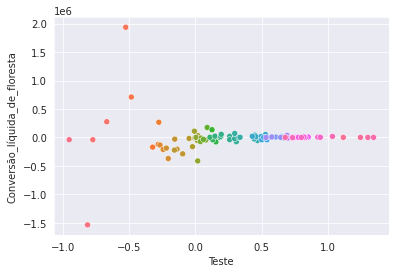

In [155]:
y_previsto = pd.DataFrame(y_previsto, index=y_test.index, columns=['Teste'])
df = pd.concat([data_test, y_previsto], axis=1)
df.sort_values(['Área_de_Floresta'], ascending=False, inplace=True)
g = sns.scatterplot(x='Teste', y='Conversão_líquida_de_floresta', data=df, hue=df.Entidade, legend=False)

<AxesSubplot:>

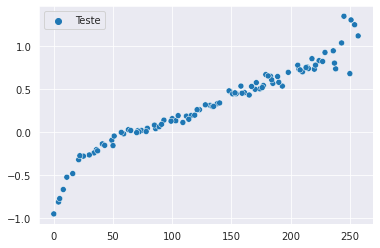

In [145]:
sns.scatterplot(data=y_previsto)

In [146]:
from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()

scores = cross_val_score(modelo, X_train, y_train, scoring='neg_mean_squared_error',
                         cv=10, n_jobs=-1)
                        
print(np.sqrt(np.mean(abs(scores))))


1.0676988859386587


In [147]:
from sklearn.linear_model import Ridge

In [148]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

scores = clf.score(X_test, y_test)
scores

0.19790784322760002

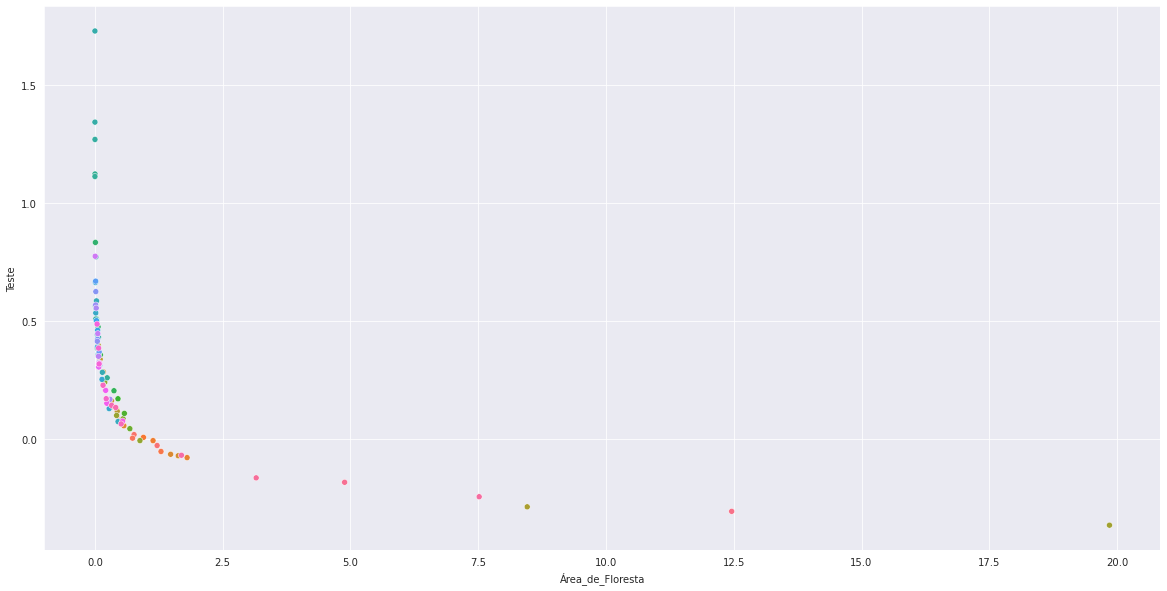

In [149]:
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=['Teste'])
dr = pd.concat([data_test, y_pred], axis=1)
g = sns.scatterplot(x='Área_de_Floresta', y='Teste', data=dr, hue=dr.Entidade, legend=False, ax=tamanhoPlot(20,10))

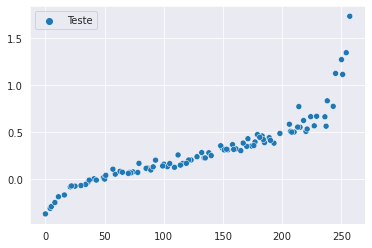

In [150]:
g = sns.scatterplot(data=y_pred)

In [151]:
folds = KFold(n_splits = 10)
scores = cross_val_score(clf, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(clf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
scores.mean()

0.9637074456152541


0.002036445357054206

In [152]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())
pcr.fit(X_train, y_train)
y_prev = pcr.predict(X_test)
y_prev.shape

(96, 1)

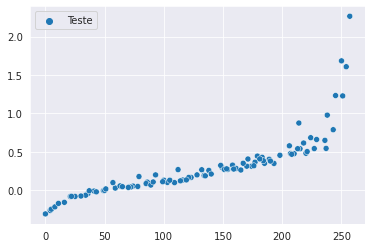

In [153]:
y_prev = pd.DataFrame(y_prev, index=y_test.index, columns=['Teste'])
dp = pd.concat([data_test, y_prev], axis=1)
g = sns.scatterplot(data=y_prev)

In [154]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
y_pls = pls.predict(X_test)
